# **Proximity Network**

In [10]:
import pandas as pd
import numpy as np 
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [11]:
bluetooth_file = "bt_file.csv"
genders_file = "genders.csv"

# **Nodes**

In [12]:
gender_df = pd.read_csv(genders_file)
gender_df.head()

,# user,female
0,0,0
1,2,0
2,3,0
3,4,0
4,5,0


In [13]:
gender_df = gender_df.rename(columns={'# user' : 'user'})

In [14]:
gender_df['female'].value_counts()

0    614
1    173
Name: female, dtype: int64

([<matplotlib.patches.Wedge at 0x2605d179700>,
 [Text(-0.7006926077430178, -0.8479562898253008, 'male'),
  Text(0.7643919357196559, 0.9250432252639644, 'female')],
 [Text(-0.38219596785982785, -0.4625216126319822, '78.0%'),
  Text(0.4458952958364659, 0.5396085480706458, '22.0%')])

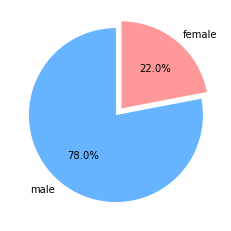

In [15]:
plt.pie(x=gender_df['female'].value_counts() ,
               explode=(0, 0.1), labels = ['male','female'],
               colors=['#66b3ff','#ff9999'],autopct='%1.1f%%',startangle=90)

# Edges

In [16]:
bt_df = pd.read_csv(bluetooth_file)
bt_df

,Unnamed: 0,# timestamp,user_a,user_b,rssi
0,36,0,49,48,-62
1,67,0,91,90,-60
2,207,0,288,104,-51
3,342,0,459,260,-38
4,439,0,611,146,-55
...,...,...,...,...,...
152536,5474180,2418900,549,161,-66
152537,5474197,2418900,569,465,-58
152538,5474237,2418900,635,542,-52
152539,5474272,2418900,694,598,-66


**Cleaning the data**

we wanna keep people who are only in the social network of the student so, we only consider it an encounter if they were 4 meter in distance, which means the rssi should be around -68

deleting the -2 values as well 

In [ ]:
nodes = gender_df['user'].to_list() # list of all nodes
edges = [tuple(e) for e in zip(calls_df['user_a'].to_list(), calls_df['user_b'].to_list())] # list of all edges

# clustering coefficient

In [24]:
def df_sub_period(period,df):
    for i,row in df.iterrows():
        if row['# timestamp']>period:
            df = df.drop(i)
    return df

to calculate the clustring coefficient we need an undirected graph

In [25]:
def create_graph(df):
    nodes = gender_df['user'].to_list() # list of all nodes
    edges = [tuple(e) for e in zip(df['user_a'].to_list(), df['user_b'].to_list())] # list of all edges
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

a week is seconds is 3600 * 24 * 7 which is 604,800 seconds

In [26]:
def weekly_graph(week,df):
    period = week * 3600 * 24
    sub_df = df_sub_period(period, df)
    G = create_graph(sub_df)
    return G
    

In [27]:
females = []
males = []
for i,row in gender_df.iterrows():
    if row['female'] == 1:
        females.append(row['user'])
    else:
        males.append(row['user'])

In [28]:
def clustring_plt(clustring_coe,gender):   
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    weeks = ['1st week', '2nd week', '3rd week', '4th week']
    ax.bar(weeks,clustring_coe)
    ax.set_title("Average Clustering Coefficient "+gender+" of Students in the Proximity Network")
    ax.set_ylabel('average value')
    ax.set_xlabel('weeks')
    plt.show()

# Females

In [29]:
def results(nodes):    
    G = weekly_graph(7, bt_df)

    first_week = nx.average_clustering(G,nodes)

    G = weekly_graph(14, bt_df)

    second_week = nx.average_clustering(G,nodes)

    G = weekly_graph(21, bt_df)

    third_week = nx.average_clustering(G,nodes)

    G = weekly_graph(28, bt_df)

    fourth_week = nx.average_clustering(G,nodes)
    
    clustring_coe = [first_week,second_week,third_week,fourth_week]
    return clustring_coe

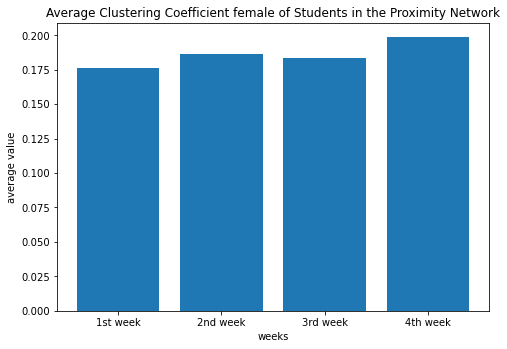

In [30]:
gender = 'female'
clustring_plt(results(females),gender)

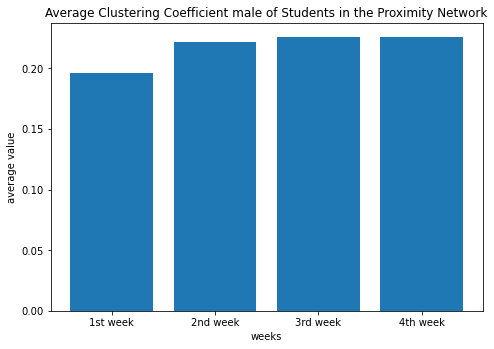

In [31]:
gender = 'male'
clustring_plt(results(males),gender)

In [32]:
clustring_plt(results(gender_df['user']),"")

KeyboardInterrupt: 

# Triangles:

In [33]:

def get_triangles(G):
    result = []
    list =[]
    nodes = G.nodes()
    for n1 in nodes:
        neighbors1 = set(G[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(G[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                result.append(n1)
                result.append(n2)
                result.append(n3)
                list.append(result)
                #yield n1, n2, n3
    return list

In [34]:
G = create_graph(bt_df)
generator = get_triangles(G)


In [35]:
all_cliques= nx.enumerate_all_cliques(G)

In [36]:
triad_cliques=[x for x in all_cliques if len(x)==3 ]

for each triangle, find if it's a homophilly or a hetrophilly, 

In [41]:

def tri(triad_cliques):
    female_homo =0
    male_homo = 0
    male_hetro =0
    female_hetro=0
    for tri in triad_cliques:
        female_count = 0
        male_count = 0
        for node in tri:
            if node in gender_df['user'].to_list():
                if gender_df.loc[gender_df['user'] == node,'female'].item() == 0:
                    male_count += 1
                else:
                    female_count += 1
        if male_count == 0:
            female_homo += 1
        elif female_count == 0:
            male_homo +=1
        elif female_count > male_count and male_count!=0:
            female_hetro += 1
        elif male_count> female_count and female_count!=0:
            male_hetro += 1
#         print(tri)
#         print("females: "+str(female_count))
#         print("males: "+str(male_count))
    print("female homophilly: "+str(female_homo))
    print("male homophilly: "+str(male_homo))
    print("male hetrophilly: "+str(male_hetro))
    print("female hetrophilly: "+str(female_hetro))
    return female_homo, female_hetro, male_homo, male_hetro

In [42]:
tri(triad_cliques)

female homophilly: 2172
male homophilly: 16841
male hetrophilly: 12033
female hetrophilly: 6040


(2172, 6040, 16841, 12033)

In [45]:
def tri_plt(tri):   
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    group = ['Females only', '2 Females, 1 Male', 'Males only', '2 Males, 1 Female']
    ax.bar(group,tri)
    ax.set_title("Gender in Triangles formed in Proximity Network")
    ax.set_ylabel('count')
    ax.set_xlabel('group')
#     for index, value in enumerate(clustring_coe):
#         plt.text(value, index, str(value))
    plt.show()

female homophilly: 2172
male homophilly: 16841
male hetrophilly: 12033
female hetrophilly: 6040


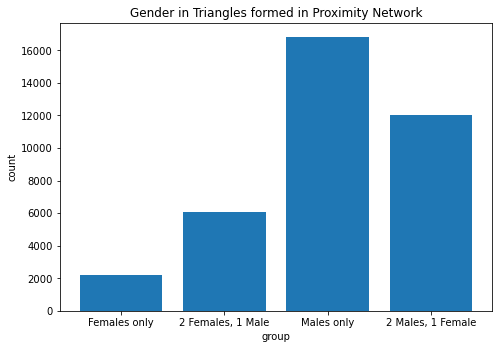

In [46]:
tri_plt(tri(triad_cliques))